In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !pip -q install gymnasium[mujoco]==1.0.0

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
from tqdm import tqdm

In [3]:
from env import make_env
env = make_env(render_mode="rgb_array")
print("Observation space: ", env.observation_space)
print("Action space: ", env.action_space)

Observation space:  Box(-inf, inf, (17,), float64)
Action space:  Box(-1.0, 1.0, (6,), float32)


In [4]:
!pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

In [5]:
xml = """
<mujoco>
  <worldbody>
    <geom name="red_box" type="box" size=".2 .2 .2" rgba="1 0 0 1"/>
    <geom name="green_sphere" pos=".2 .2 .2" size=".1" rgba="0 1 0 1"/>
  </worldbody>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(xml)

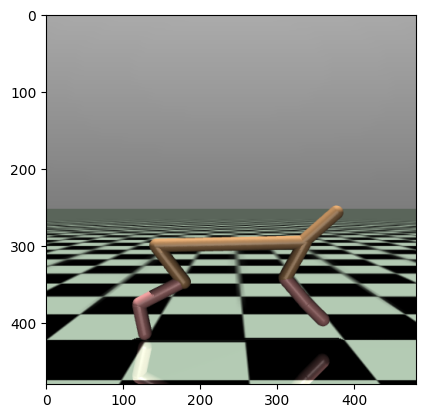

In [6]:
import matplotlib.pyplot as plt

env.reset()
plt.imshow(env.render())

In [7]:
from env import make_vec_env
# Parameters
n_envs = 2  # Number of parallel environments
# Create the vectorized environment
vec_env = make_vec_env(n_envs)

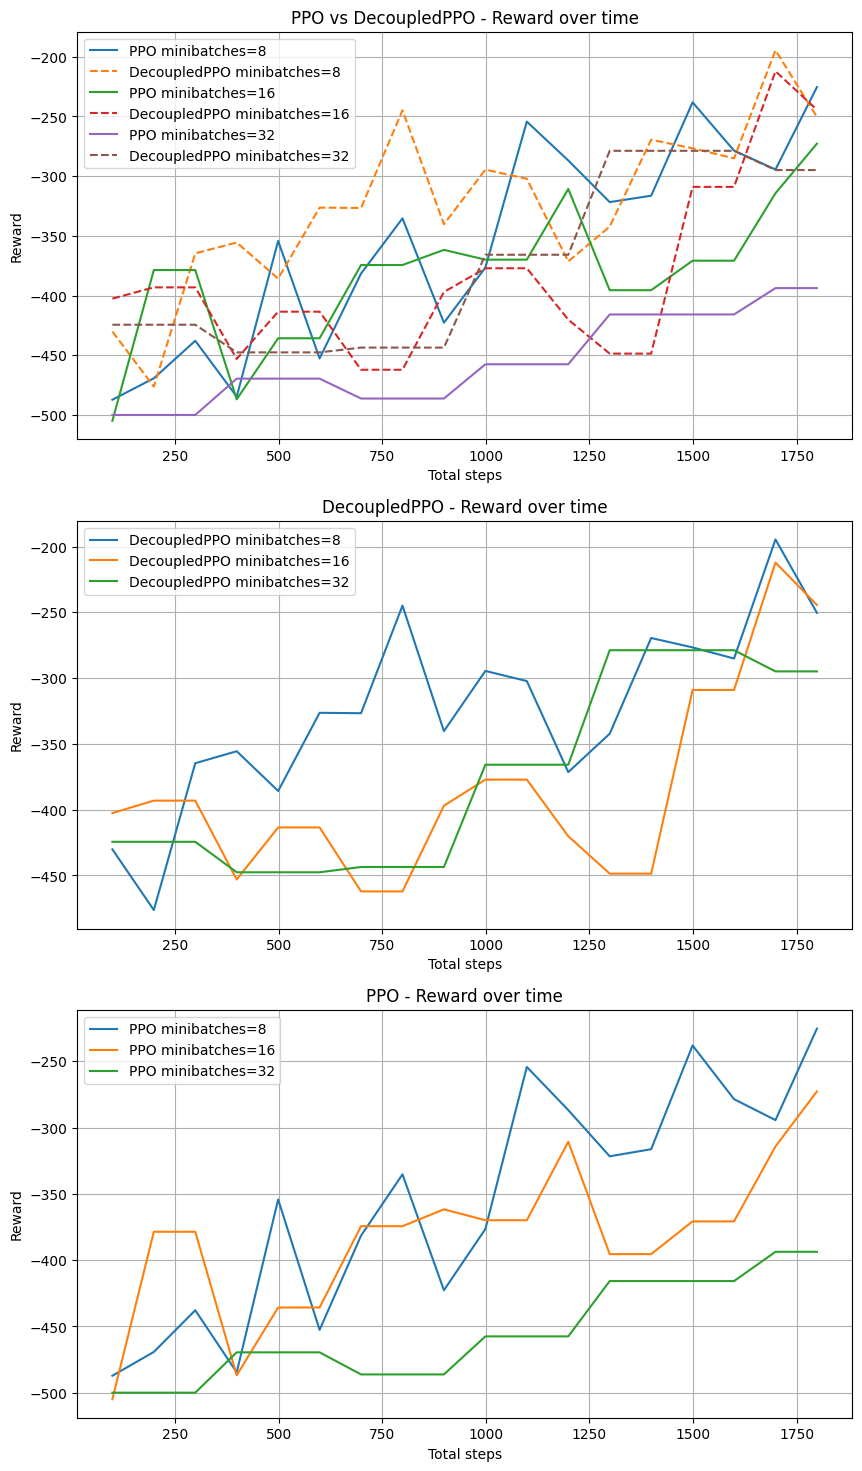

  1%|          | 1839/150000 [04:01<1:15:27, 32.72it/s]

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from policy import PolicyModel, Policy
from ppo import make_ppo_sampler, DecoupledPPO, PPO
from adam import rescale_adam
from IPython.display import clear_output

# Создаём окружения
num_envs = 2
envs = {num_minibatches: make_vec_env(num_envs=num_envs) for num_minibatches in [8, 16, 32]}

# Определяем размеры состояний и действий
state_dim = envs[8].single_observation_space.shape[0]
action_dim = envs[8].single_action_space.shape[0]

# Создаём модели
models = {}
optimizers = {}
ppos = {}
schedulers = {}
num_default_minibatches = 32
num_minibatches_list = [8, 16, 32]  # Разные размеры мини-батчей

for num_minibatches in num_minibatches_list:
    for algo in [PPO, DecoupledPPO]:  # Добавляем обычный PPO и DecoupledPPO
        env_curr = make_vec_env(num_envs=num_envs)
        model = PolicyModel(state_dim, action_dim).cpu()
        policy = Policy(model)
        
        sampler = make_ppo_sampler(env_curr, policy, num_minibatches=num_minibatches)
        optimiczer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, eps=1e-5)
        rescale_adam(optimizer=optimizer, C=num_default_minibatches / num_minibatches)
        
        if algo is DecoupledPPO:
            C = num_default_minibatches / num_minibatches
            beta_ewma = 0.99
            beta_ewma = 1 - (1 / (1 + (C * beta_ewma) / (1 - beta_ewma))) 
            ppo = algo(policy, optimizer, beta_ewma=beta_ewma)
        else:
            ppo = algo(policy, optimizer)
        lr_mult = lambda epoch: (1 - (epoch / 150000))
        sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)
        
        models[(algo.__name__, num_minibatches)] = (policy, sampler, ppo, env_curr)
        optimizers[(algo.__name__, num_minibatches)] = optimizer
        schedulers[(algo.__name__, num_minibatches)] = sched

# Инициализируем массивы для хранения результатов
steps = []
rewards = {(algo.__name__, num_minibatches): [] for num_minibatches in num_minibatches_list for algo in [PPO, DecoupledPPO]}
n_update = 100  # Как часто обновлять график

# Основной цикл обучения
n_iter = 150000
for i in tqdm(range(n_iter)):
    for key in models:
        policy, sampler, ppo, env_curr = models[key]
        optimizer = optimizers[key]
        sched = schedulers[key]
        
        trajectory = sampler.get_next()
        ppo.step(trajectory)
        sched.step()
    
    if (i + 1) % n_update == 0:
        steps.append(i)
        for key in models:
            env_curr = models[key][-1]
            rewards[key].append(env_curr.env.env.env.return_queue[-1])
        
        clear_output(wait=True)  # Удаляет старый график перед обновлением
        plt.figure(figsize=(10, 18))
        
        plt.subplot(3, 1, 1)
        for num_minibatches in num_minibatches_list:
            plt.plot(steps, rewards[("PPO", num_minibatches)], label=f"PPO minibatches={num_minibatches}")
            plt.plot(steps, rewards[("DecoupledPPO", num_minibatches)], '--', label=f"DecoupledPPO minibatches={num_minibatches}")
        
        plt.legend()
        plt.title("PPO vs DecoupledPPO - Reward over time")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()

        # График 2: Только DecoupledPPO с разными размерами мини-батчей
        plt.subplot(3, 1, 2)
        for num_minibatches in num_minibatches_list:
            plt.plot(steps, rewards[("DecoupledPPO", num_minibatches)], label=f"DecoupledPPO minibatches={num_minibatches}")
        
        plt.legend()
        plt.title("DecoupledPPO - Reward over time")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()

        # График 3: Только PPO с разными размерами мини-батчей
        plt.subplot(3, 1, 3)
        for num_minibatches in num_minibatches_list:
            plt.plot(steps, rewards[("PPO", num_minibatches)], label=f"PPO minibatches={num_minibatches}")
        
        plt.legend()
        plt.title("PPO - Reward over time")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()

        plt.show()
        
       
        plt.show()


In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt

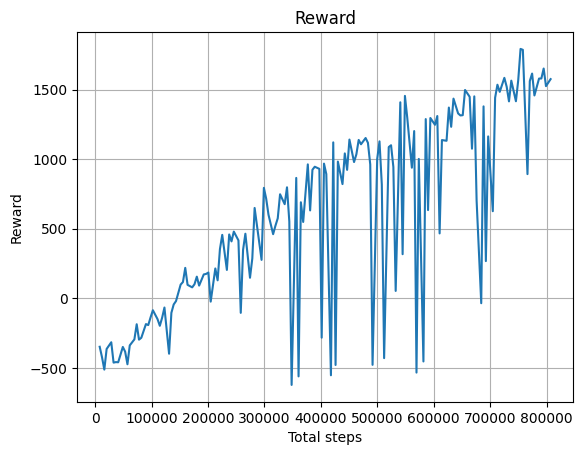

  6%|▋         | 15703/250000 [09:54<2:27:51, 26.41it/s]


KeyboardInterrupt: 

In [30]:
steps = []
rewards = []

for i in tqdm(range(n_iter)):
    trajectory = sampler.get_next()

    if (i + 1) % 100 == 0:
        clear_output(True)
        rewards.append(vec_env.env.env.env.return_queue[-1])
        steps.append(sampler.runner.step_var)

        plt.plot(steps, rewards, label="episode rewards")
        plt.title("Reward")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

    ppo.step(trajectory)
    sched.step()

In [31]:
state_dim = vec_env.single_observation_space.shape[0]
action_dim = vec_env.single_action_space.shape[0]

model = PolicyModel(state_dim, action_dim)
model = model.cpu() # Free colab dont have cuda :(

policy = Policy(model)

num_envs = 2

num_default_minibatches = 8
num_minibatches = 8

vec_env = make_vec_env(num_envs=num_envs)
sampler = make_ppo_sampler(
    vec_env,
    policy,
    num_minibatches=num_minibatches)

optimizer = torch.optim.Adam(policy.model.parameters(), lr=3e-4, eps=1e-5)
rescale_adam(optimizer=optimizer, C=num_default_minibatches / num_minibatches)
n_iter = 250000

lr_mult = lambda epoch: (1 - (epoch / n_iter))
sched = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_mult)

ppo = DecoupledPPO(policy, optimizer)

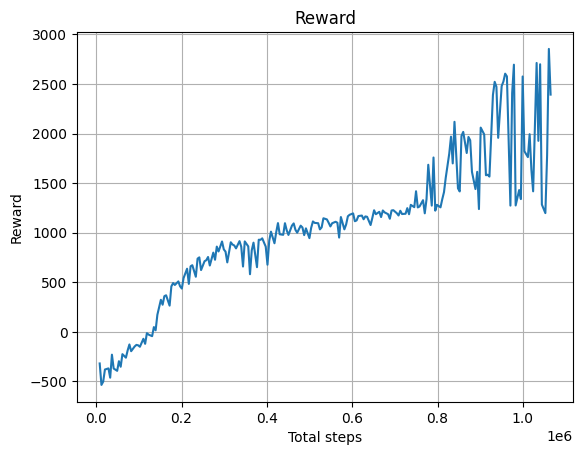

  8%|▊         | 20880/250000 [12:16<2:14:44, 28.34it/s]


KeyboardInterrupt: 

In [32]:
steps = []
rewards = []

for i in tqdm(range(n_iter)):
    trajectory = sampler.get_next()

    if (i + 1) % 100 == 0:
        clear_output(True)
        rewards.append(vec_env.env.env.env.return_queue[-1])
        steps.append(sampler.runner.step_var)

        plt.plot(steps, rewards, label="episode rewards")
        plt.title("Reward")
        plt.xlabel("Total steps")
        plt.ylabel("Reward")
        plt.grid()
        plt.show()

    ppo.step(trajectory)
    sched.step()

## Evaluation

In [79]:
def evaluate(env, actor, n_games=1, t_max=1000):
    """
    Plays n_games and returns rewards and rendered games
    """
    rewards = []

    for _ in range(n_games):
        s, _ = env.reset()

        R = 0
        for _ in range(t_max):
            # select action for final evaluation of your policy
            action = actor.act(np.array([s]), training=False)["actions"]

            s, r, terminated, truncated, _ = env.step(action)

            R += r

            if terminated or truncated:
                break

        rewards.append(R)
    return np.array(rewards)

In [80]:
from gymnasium.wrappers import (
    RecordVideo,
    NormalizeObservation as SingleEnvNormalization,
)

# let's hope this will work
# don't forget to pray
test_env = gym.make("HalfCheetah-v5", render_mode="rgb_array")
test_env = SingleEnvNormalization(test_env)
test_env.obs_rms = (
    vec_env.env.env.obs_rms
)  # use the same statistics collected on training
env_monitor = RecordVideo(env=test_env, video_folder="./videos")
results = evaluate(env_monitor, policy, n_games=5, t_max=1000)

print(results)

/Users/ilyaparfenenko/Library/Python/3.9/lib/python/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/ilyaparfenenko/Downloads/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


[2306.94726506 2203.71880969 2341.47620745 2207.04956891 2162.29598199]


In [81]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[-1]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)